## Train kaggle fish model

A tranfer learning model build upon InceptionV3 for the competition

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

The kaggle data is downloaded to data/train.

In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization
from keras import backend as K

Using TensorFlow backend.


(720, 1280, 3)

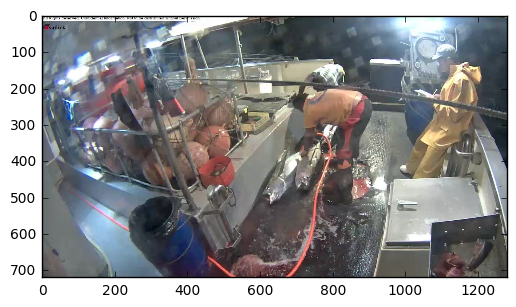

In [4]:
## TEST ONE PICTURE ##
from keras.preprocessing.image import load_img, img_to_array
from matplotlib.pyplot import imshow
%matplotlib inline
im = load_img('data/train/ALB/img_00029.jpg')
imshow(im)
img_to_array(im).shape

In [5]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))


In [6]:
from keras.layers.core import Dropout
for layer in base_model.layers:
    layer.trainable = False
        
## ADD FINAL LAYER
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(8, activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

In [7]:
### DATA GENERATOR ###
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rescale=1./255
        )

train_generator = datagen.flow_from_directory(
    'data/train',
    target_size = (299,299),
    batch_size=64,
    class_mode="categorical"
)

validation_generator = datagen.flow_from_directory(
    'data/validation/',
    target_size = (299,299),
    batch_size=64,
    class_mode="categorical"
)

Found 2676 images belonging to 8 classes.
Found 1101 images belonging to 8 classes.


In [8]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, epsilon = 0.01,
                  patience=2, min_lr=0.0000001, verbose = 1)

#checkpoint = ModelCheckpoint("model_checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5", 
#                             monitor=['val_loss','accuracy'])

csv_logger = CSVLogger("training.log", separator=',', append=True)


## Train our new layers while freezing the others

In [9]:

for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


model.fit_generator(
        train_generator,
    validation_data = validation_generator,
    samples_per_epoch=2000,
    nb_val_samples = 500,
    nb_epoch=10,
    callbacks = [reduce_lr, csv_logger])

Epoch 1/10
1984/2000 [============================>.] - ETA: 0s - loss: 1.6172 - acc: 0.5837

/usr/local/lib64/python2.7/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


2048/2000 [==============================] - 107s - loss: 1.5921 - acc: 0.5879 - val_loss: 1.4442 - val_acc: 0.5957
Epoch 2/10
2036/2000 [==============================] - 92s - loss: 0.5621 - acc: 0.8188 - val_loss: 1.0524 - val_acc: 0.7162
Epoch 3/10
2036/2000 [==============================] - 82s - loss: 0.3753 - acc: 0.8816 - val_loss: 0.6092 - val_acc: 0.8359
Epoch 4/10
2036/2000 [==============================] - 82s - loss: 0.2840 - acc: 0.9013 - val_loss: 0.5507 - val_acc: 0.8762
Epoch 5/10
2048/2000 [==============================] - 82s - loss: 0.2105 - acc: 0.9316 - val_loss: 0.5073 - val_acc: 0.8691
Epoch 6/10
2036/2000 [==============================] - 82s - loss: 0.1475 - acc: 0.9524 - val_loss: 0.5309 - val_acc: 0.9048
Epoch 7/10
2036/2000 [==============================] - 82s - loss: 0.1854 - acc: 0.9455 - val_loss: 0.4671 - val_acc: 0.9121
Epoch 8/10
2036/2000 [==============================] - 81s - loss: 0.1628 - acc: 0.9607 - val_loss: 0.4233 - val_acc: 0.9219
Ep

## Train more layers as well

In [10]:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

model.fit_generator(
        train_generator,
    validation_data = validation_generator,
    samples_per_epoch=2000,
    nb_val_samples = 500,
    nb_epoch=10,
    callbacks = [reduce_lr, csv_logger])

Epoch 1/10
2036/2000 [==============================] - 134s - loss: 0.0594 - acc: 0.9823 - val_loss: 0.4718 - val_acc: 0.9086
Epoch 2/10
2036/2000 [==============================] - 92s - loss: 0.0464 - acc: 0.9853 - val_loss: 0.4438 - val_acc: 0.9199
Epoch 3/10
2036/2000 [==============================] - 91s - loss: 0.0357 - acc: 0.9887 - val_loss: 0.5005 - val_acc: 0.9160
Epoch 4/10
2048/2000 [==============================] - 92s - loss: 0.0265 - acc: 0.9907 - val_loss: 0.4697 - val_acc: 0.9238
Epoch 5/10
2036/2000 [==============================] - 91s - loss: 0.0305 - acc: 0.9887 - val_loss: 0.4140 - val_acc: 0.9355
Epoch 6/10
2036/2000 [==============================] - 91s - loss: 0.0190 - acc: 0.9931 - val_loss: 0.4194 - val_acc: 0.9181
Epoch 7/10
2036/2000 [==============================] - 91s - loss: 0.0168 - acc: 0.9941 - val_loss: 0.3929 - val_acc: 0.9219
Epoch 8/10
2048/2000 [==============================] - 92s - loss: 0.0167 - acc: 0.9966 - val_loss: 0.3761 - val_acc

In [14]:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

model.fit_generator(
        train_generator,
    validation_data = validation_generator,
    samples_per_epoch=2000,
    nb_val_samples = 500,
    nb_epoch=10,
    callbacks = [reduce_lr, csv_logger])

Epoch 1/10
2036/2000 [==============================] - 130s - loss: 0.0123 - acc: 0.9975 - val_loss: 0.4139 - val_acc: 0.9316
Epoch 2/10
2036/2000 [==============================] - 91s - loss: 0.0154 - acc: 0.9956 - val_loss: 0.3940 - val_acc: 0.9297
Epoch 3/10
2036/2000 [==============================] - 95s - loss: 0.0099 - acc: 0.9966 - val_loss: 0.4216 - val_acc: 0.9429
Epoch 4/10
2048/2000 [==============================] - 92s - loss: 0.0069 - acc: 0.9985 - val_loss: 0.4480 - val_acc: 0.9395
Epoch 5/10
1972/2000 [============================>.] - ETA: 1s - loss: 0.0117 - acc: 0.9965
Epoch 00004: reducing learning rate to 1.99999994948e-05.
2036/2000 [==============================] - 92s - loss: 0.0114 - acc: 0.9966 - val_loss: 0.4607 - val_acc: 0.9238
Epoch 6/10
2036/2000 [==============================] - 91s - loss: 0.0144 - acc: 0.9951 - val_loss: 0.3150 - val_acc: 0.9473
Epoch 7/10
2036/2000 [==============================] - 92s - loss: 0.0274 - acc: 0.9917 - val_loss: 0.

In [15]:
test_path = 'data/test_stg1/'
test_images = os.listdir(test_path)

preds = list()
names = list()
for im in test_images:
    x = img_to_array(load_img(test_path+im,target_size=(299, 299)))
    x = np.expand_dims(x, axis=0)/255.
    r = model.predict(x)
    names.append(im)
    preds.append(r)

In [16]:
import pandas as pd
classPreds = pd.DataFrame(np.concatenate(preds), 
                          columns=['ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT']).clip(0.2,0.8)
classPreds['image'] = names

arrCol = ['image','ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT']

classPreds[arrCol].to_csv("submission_clipped.csv",index=False)

In [18]:
classPreds = pd.DataFrame(np.concatenate(preds), 
                          columns=['ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT']).clip(0.2,0.8)

In [36]:
fish = []
freq = []
for cat in categories:
    images = os.listdir(raw_path+cat)
    freq.append(len(images))
    fish.append(cat)

freq = np.array(freq)
freq = freq*1.0/np.sum(freq)

In [38]:
zip(fish,freq)

[('DOL', 0.030976965845909452),
 ('YFT', 0.19433412761450886),
 ('ALB', 0.45512311358220808),
 ('BET', 0.052952078369075985),
 ('SHARK', 0.046597828964786869),
 ('NoF', 0.12311358220810167),
 ('OTHER', 0.079163357161768602),
 ('LAG', 0.017738946253640454)]

In [40]:
preds = classPreds.idxmax(axis=1)
preds.value_counts(normalize=True)

ALB      0.546
YFT      0.197
NoF      0.157
OTHER    0.027
BET      0.026
DOL      0.019
LAG      0.018
SHARK    0.010
dtype: float64